# A1: Data Curation Assignment

Patrick Peng (ID: 2029888)  
DATA 512 AU 2021

## Step 1: Data acquisition

First, we follow the example code given to make API calls.

In [1]:
import json
import requests

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers = {
    'User-Agent': 'https://github.com/ppeng2',
    'From': 'ppeng2@uw.edu'
}

Below are a couple of helper functions to generate the parameter lists for the API calls. Since the two APIs take different parameter lists, there is one function for each API.

In [3]:
def legacy_params(access_type,start_yr,start_month,end_yr,end_month):
    # Generate parameters dict for legacy pagecount API
    # dates in  YYMMDDHH format
    start = start_yr*1e6 + start_month*1e4 + 100
    if end_month < 12:
        end = end_yr*1e6 + (end_month+1)*1e4 + 100
    else:
        end = (end_yr+1)*1e6 + (1)*1e4 + 100
        
    return {"project" : "en.wikipedia.org",
                 "access-site" : access_type,
                 "granularity" : "monthly",
                 "start" : str(int(start)),
                # for end use 1st day of month following final month of data
                 "end" : str(int(end))
                    }

def pageview_params(access_type,start_yr,start_month,end_yr,end_month):
    # Generate parameters dict for pageviews API
    # dates in  YYMMDDHH format
    start = start_yr*1e6 + start_month*1e4 + 100
    if end_month < 12:
        end = end_yr*1e6 + (end_month+1)*1e4 + 100
    else:
        end = (end_yr+1)*1e6 + (1)*1e4 + 100
        
    return {"project" : "en.wikipedia.org",
                    "access" : access_type,
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : str(int(start)),
                    # for end use 1st day of month following final month of data
                    "end" : str(int(end))
                        }

And here is a helper function that performs the API call and saves its result in a JSON file.

In [4]:
def get_data(apiname,access_type,start_yr,start_month,end_yr,end_month):
    # Performs API call and saves result in JSON
    if apiname == 'pagecounts': # legacy API
        params = legacy_params(access_type,start_yr,start_month,end_yr,end_month)
        endpoint = endpoint_legacy
    elif apiname == 'pageviews': # new API
        params = pageview_params(access_type,start_yr,start_month,end_yr,end_month)
        endpoint = endpoint_pageviews
        
    call = requests.get(endpoint.format(**params), headers=headers)
    response = call.json()
    filename = apiname + '_' + access_type +'_' + str(int(start_yr*100 + start_month)) + '-' + str(int(end_yr*100 + end_month)) + '.json'
    print(filename)
    with open(filename,'w',encoding='utf-8') as f:
        json.dump(response, f, ensure_ascii=False,indent=4)

Here, we run the `get_data` function above for the five different API/access combinations. The filenames are printed as outputs.

In [5]:
get_data('pagecounts','desktop-site',2007,12,2016,7)
get_data('pagecounts','mobile-site',2007,12,2016,7)
get_data('pageviews','desktop',2015,7,2021,8)
get_data('pageviews','mobile-app',2015,7,2021,8)
get_data('pageviews','mobile-web',2015,7,2021,8)


pagecounts_desktop-site_200712-201607.json
pagecounts_mobile-site_200712-201607.json
pageviews_desktop_201507-202108.json
pageviews_mobile-app_201507-202108.json
pageviews_mobile-web_201507-202108.json


## Step 2: Data Processing

In [6]:
import pandas as pd

Here is a helper function to read the JSON files we created in Step 1 and save their result in a Pandas DataFrame. It also modifies the columns and their names (for easier pivoting later) and creates Year and Month columns from the timestamps.

In [39]:
def json2df(path):
    # Turn input JSON into a Pandas Dataframe
    f = open(path)
    data = json.load(f)
    f.close()
    df = pd.DataFrame(data['items'])
    
    # make column names consistent
    if 'pagecounts' in path:  # legacy API
        df.drop(columns=['project','granularity'],inplace = True)
        df.rename(columns={'access-site':'access','count':'views'},inplace = True)
    elif 'pageviews' in path:  # new API
        df.drop(columns=['project','agent','granularity'],inplace = True)
    
    #df['year'] = df['timestamp'].map(lambda x: int(x[0:4]))
    #df['month'] = df['timestamp'].map(lambda x: int(x[4:6]))
    
    df.insert(0,'year',df['timestamp'].map(lambda x: int(x[0:4])))
    df.insert(1,'month',df['timestamp'].map(lambda x: int(x[4:6])))
    df.drop(columns = 'timestamp',inplace=True)
    return df
        

And now we run the `json2df` helper function on our 5 JSON files to create the dataframes. 

In [40]:
legacy_desktop = json2df('pagecounts_desktop-site_200712-201607.json')
legacy_mobile = json2df('pagecounts_mobile-site_200712-201607.json')
pv_desktop = json2df('pageviews_desktop_201507-202108.json')
pv_app = json2df('pageviews_mobile-app_201507-202108.json')
pv_mobileweb = json2df('pageviews_mobile-web_201507-202108.json')

Next, we combine the PageView mobile app and mobile web counts into a single count for Pageview mobile. Since the two dataframes have the same dimensions (as expected, since the requested date ranges are identical), we can just add the columns directly.

In [60]:
# Combine the Pageviews app and mobile web counts
pv_mobile = pv_app.copy(deep=True)
pv_mobile['views'] = pv_app['views']+pv_mobileweb['views']
pv_mobile['access'] = 'mobile-all'

Now we can concatenate the Pagecount desktop, Pagecount mobile, Pageviews desktop, and Pageviews mobile DataFrames into a single Dataframe, which we will then pivot.

In [62]:
prepivot = pd.concat([legacy_desktop,legacy_mobile,pv_desktop,pv_mobile])

In [65]:
df_pivot=prepivot.pivot_table(values='views', index=['year','month'],columns=['access'])

Since the resulting pivot table has NaNs where data is unavailable, we replace them with zeros.

In [67]:
df_pivot.fillna(value=0,inplace=True)

Next, we'll rename the columns headers to the ones specified.

In [72]:
df_pivot.rename(columns={
    'desktop':'pageview_desktop_views',
    'desktop-site':'pagecount_desktop_views',
    'mobile-all':'pageview_mobile_views',
    'mobile-site':'pagecount_mobile_views'
}, inplace=True)

Finally, we have to calculate `all_views` columns for both Pagecount and Pageviews. Then we'll reorder the columns to the desired order.

In [75]:
df_pivot['pagecount_all_views'] = df_pivot['pagecount_desktop_views']+df_pivot['pagecount_mobile_views']
df_pivot['pageview_all_views'] = df_pivot['pageview_desktop_views']+df_pivot['pageview_mobile_views']

df_pivot = df_pivot[['pagecount_all_views','pagecount_desktop_views','pagecount_mobile_views',
                    'pageview_all_views','pageview_desktop_views','pageview_mobile_views']]

In [78]:
df_pivot.head(10)

access      pagecount_all_views  pagecount_desktop_views  \
year month                                                 
2007 12            2.998332e+09             2.998332e+09   
2008 1             4.930903e+09             4.930903e+09   
     2             4.818394e+09             4.818394e+09   
     3             4.955406e+09             4.955406e+09   
     4             5.159162e+09             5.159162e+09   
     5             5.584691e+09             5.584691e+09   
     6             5.712104e+09             5.712104e+09   
     7             5.306303e+09             5.306303e+09   
     8             5.140156e+09             5.140156e+09   
     9             5.479534e+09             5.479534e+09   

access      pagecount_mobile_views  pageview_all_views  \
year month                                               
2007 12                        0.0                 0.0   
2008 1                         0.0                 0.0   
     2                         0.0                 0.0   
     3                         0.0                 0.0   
     4                         0.0                 0.0   
     5                         0.0                 0.0   
     6                         0.0                 0.0   
     7                         0.0                 0.0   
     8                         0.0                 0.0   
     9                         0.0                 0.0   

access      pageview_desktop_views  pageview_mobile_views  
year month                                                 
2007 12                        0.0                    0.0  
2008 1                         0.0                    0.0  
     2                         0.0                    0.0  
     3                         0.0                    0.0  
     4                         0.0                    0.0  
     5                         0.0                    0.0  
     6                         0.0                    0.0  
     7                         0.0                    0.0  
     8                         0.0                    0.0  
     9                         0.0                    0.0

Now we'll save the resulting DataFrame to a CSV file.

In [77]:
df_pivot.to_csv('en-wikipedia_traffic_200712-202108.csv')

## Step 3: Analysis

In [79]:
import matplotlib.pyplot as plt
import datetime

<AxesSubplot:title={'center':'English Wikipedia Views by Access Type'}, xlabel='Year & Month', ylabel='Views (tens of billions)'>

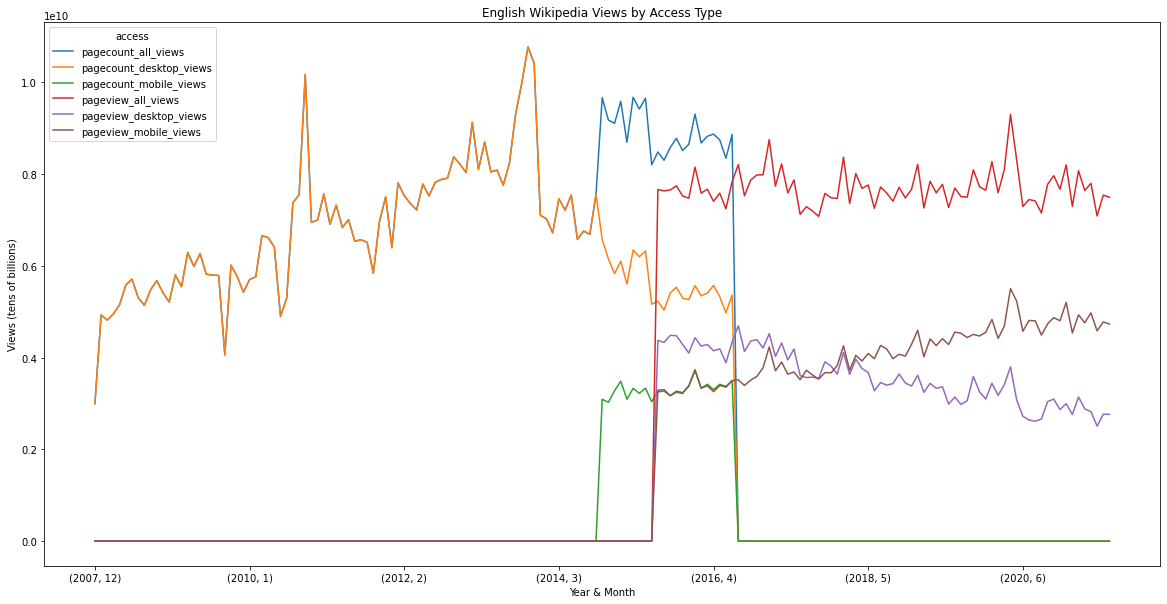

In [85]:
df_pivot.plot(figsize=(20,10),xlabel='Year & Month', ylabel='Views (tens of billions)',title='English Wikipedia Views by Access Type')